In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import copy
import torch
import csv
from abc_env import ABC_env
from naive_agents import DoNothing, FixedPhi
#from dynamic_phi_agent import DynamicPhiAgent
from actor_physicists_abc import RL_phi_agent

In [2]:
# PARAMS
A = 1.
B = 0.7
C = 0.43
NU = 0.99
kappa = 0.001
BETA = 0.1
baseline_phi = 0.4
D = 0.08 # placeholder for now
dims = 3

In [3]:
def compare_agents(agent_list,identfiers, sep_size=0.5,num_eps=100,time_horizon=10.):
    label_index=0
    labels=[]
    colors = ["C2","C1"]
    agent_number=0
    
    for agent in agent_list:
        env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
        env.limit = time_horizon
        cum_rew=np.zeros(int(env.limit/env.deltaT))
        for i in range(0,num_eps):
            time_step=0
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                #if type(agent)==RL_phi_agent:
                #    action=agent.sample_deterministic_action(env.getState())
                #else:
                #    action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
                cum_rew[time_step] += episode_rew
                time_step += 1
            #if env.dist() > 0.5:
            #    print("Catastrophic failure:")
            #    print(episode_rew)
            env.reset()
        if agent_number%2 == 0:
            plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps,f"{colors[agent_number//2]}")
        else:
            plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps, f"{colors[agent_number//2]}--")
        labels.append(identfiers[label_index])
        label_index+=1
        agent_number +=1
    
        
    plt.legend(labels)
    plt.title(f"Avg Cumalative Reward")
    plt.xlabel("episode time")
    plt.ylabel("reward")

In [4]:
def compare_agents_avg_return(agent_list,identfiers, sep_size=0.2*np.pi,num_eps=100,time_horizon=10.):
    final_summed_rewards = []
    agent_episode_rewards = {}
    agent_id = 0
    
    for agent in agent_list:
        agent_episode_rewards[identfiers[agent_id]] = []
        env = ABC_env(A,B,C,sep_size,BETA,kappa,D,NU)
        env.limit = time_horizon
        summed_rew = 0
        for i in range(0,num_eps):
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
            agent_episode_rewards[identfiers[agent_id]].append(episode_rew)
            summed_rew += episode_rew
            env.reset()
        final_summed_rewards.append(summed_rew)
        agent_id += 1
        
        
        
    print(f"Average rewards over {num_eps} episodes:\n")
    for i in range(len(identfiers)):
        name = identfiers[i]
        avg_rew = final_summed_rewards[i]/num_eps
        print(f"{name:<15} {avg_rew:.5f}")
    
    
    return agent_episode_rewards

In [5]:
phis = [0.6,1.1,1.6,2.1]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(dims,action_scale=5.)
    trained.load_policy(f"saved_models/abc_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    
sampled_rewards = compare_agents_avg_return(agents,identifiers,num_eps=1000)

Average rewards over 1000 episodes:

fixed_0.6       -0.40784
RL_trained_0.6  -0.34884
fixed_1.1       -0.32381
RL_trained_1.1  -0.36321
fixed_1.6       -0.40041
RL_trained_1.6  -0.31272
fixed_2.1       -0.49141
RL_trained_2.1  -0.34564


In [83]:
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{1.1}_10.0_D=0.08_eps=500.pt")
agents = [FixedPhi(1.1),trained]
identifiers = ["fixed_1.1","trained_1.1_ep=500"]
sampled_rewards_single = compare_agents_avg_return(agents,identifiers,num_eps=1000)

Average rewards over 1000 episodes:

fixed_1.1       -0.32451
trained_1.1_ep=500 -3.29944


fixed_0.6
RL_trained_0.6
fixed_1.1
RL_trained_1.1
fixed_1.6
RL_trained_1.6
fixed_2.1
RL_trained_2.1


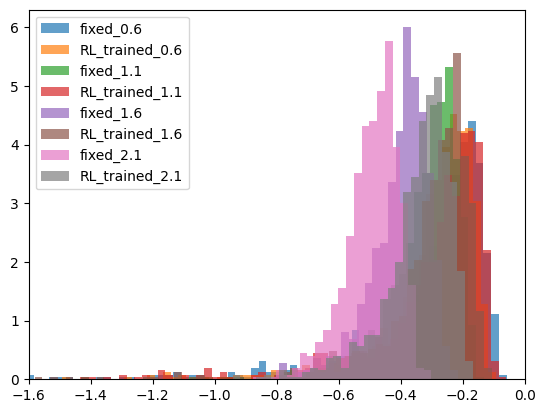

In [10]:
binwidth = 0.025
labels = []
for agent,rewards in sampled_rewards.items():
    plt.hist(rewards,bins=np.arange(min(rewards), max(rewards) + binwidth, binwidth),density=True,alpha=0.7)
    labels.append(agent)
    plt.xlim(-1.6,0)
plt.legend(labels=labels)

Text(0, 0.5, 'probability')

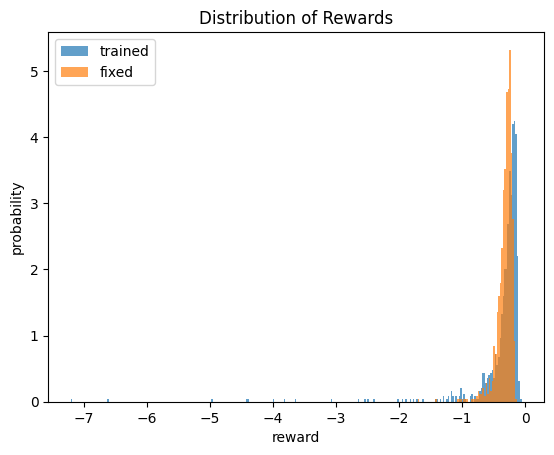

In [25]:
plt.hist(sampled_rewards["RL_trained_1.1"],bins=np.arange(min(sampled_rewards["RL_trained_1.1"]), max(sampled_rewards["RL_trained_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
#plt.xlim(-1.6,0)
plt.legend(labels=["trained","fixed"])
plt.title("Distribution of Rewards")
plt.xlabel("reward")
plt.ylabel("probability")

In [20]:
np.median(sampled_rewards["RL_trained_1.1"])

-0.24579815920878828

In [21]:
np.median(sampled_rewards["fixed_1.1"])

-0.2933499087511806

In [9]:
with open(f'csv/abc_results_params{A},{B},{C},{BETA},{kappa},{D},{NU}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(sampled_rewards.keys()))
    writer.writeheader()
    writer.writerow(sampled_rewards)

In [ ]:
assert(1==0)

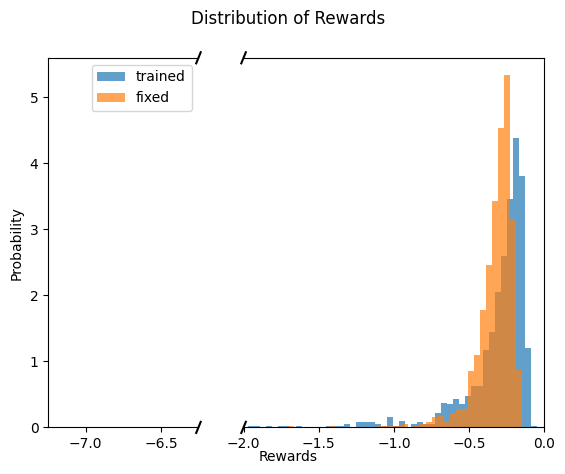

In [79]:
binwidth=0.04
fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w',gridspec_kw={'width_ratios': [1, 2]})

# plot the same data on both axes

ax.hist(sampled_rewards["RL_trained_1.1"],bins=np.arange(min(sampled_rewards["RL_trained_1.1"]), max(sampled_rewards["RL_trained_1.1"]) + 2*binwidth, 2*binwidth),density=True,alpha=0.7)
ax.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + 2*binwidth, 2*binwidth),density=True,alpha=0.7)
ax2.hist(sampled_rewards["RL_trained_1.1"],bins=np.arange(min(sampled_rewards["RL_trained_1.1"]), max(sampled_rewards["RL_trained_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
ax2.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
ax.legend(labels=["trained","fixed"])
ax.set_xlim(-7.25, -6.25)
ax2.set_xlim(-2., 0.)

#ax.set_ylim()
#ax.set_yscale("log")
ax2.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
"""
# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright='off')
ax2.yaxis.tick_right()
"""
# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
# (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d/2, +d/2), (1-d, 1+d), **kwargs)
ax2.plot((-d/2, +d/2), (-d, +d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax.set_ylabel("Probability")
fig.suptitle('Distribution of Rewards')
fig.text(0.5, 0.04, 'Rewards', ha='center')
plt.show()

In [23]:
sampled_rewards

{'fixed_0.6': [-0.21000878853089128,
  -0.5835841437215279,
  -0.27073220792180014,
  -0.38584270055839126,
  -0.24816177278363705,
  -0.33611355338836535,
  -0.38505269576799245,
  -0.3320511578146858,
  -0.29669622159814424,
  -0.2539038187629447]}

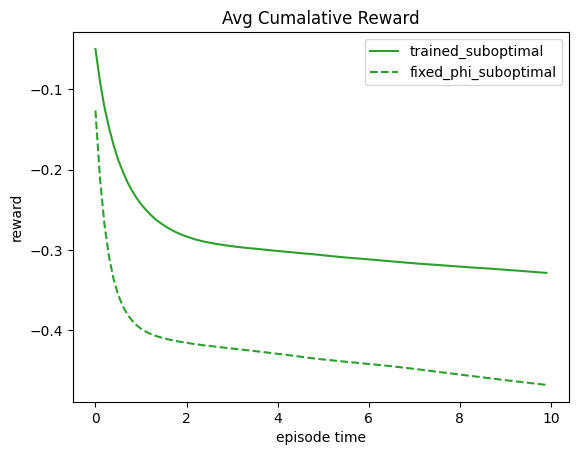

In [4]:
baseline_phi = 2.0
fixed_phi = FixedPhi(baseline_phi) # need to retune
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{baseline_phi}_10.0.pt")
compare_agents([ trained , fixed_phi],
              ["trained_suboptimal", "fixed_phi_suboptimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

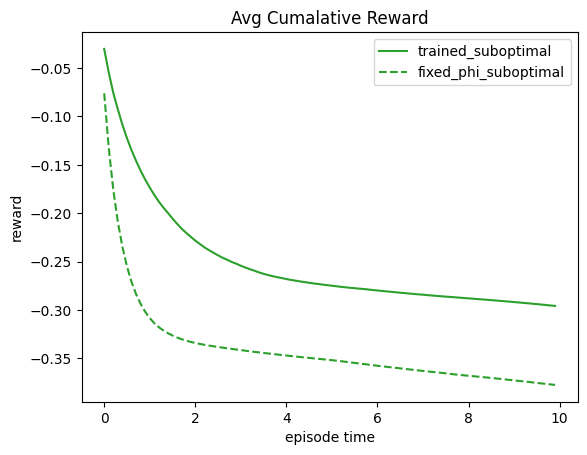

In [5]:
baseline_phi = 1.5
fixed_phi = FixedPhi(baseline_phi) # need to retune
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{baseline_phi}_10.0.pt")
compare_agents([ trained , fixed_phi],
              ["trained_suboptimal", "fixed_phi_suboptimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

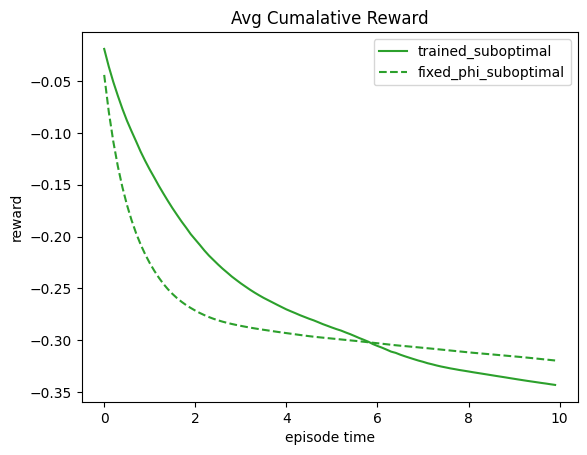

In [6]:
baseline_phi = 1.1
fixed_phi = FixedPhi(baseline_phi) # need to retune
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{baseline_phi}_10.0.pt")
compare_agents([ trained , fixed_phi],
              ["trained_suboptimal", "fixed_phi_suboptimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

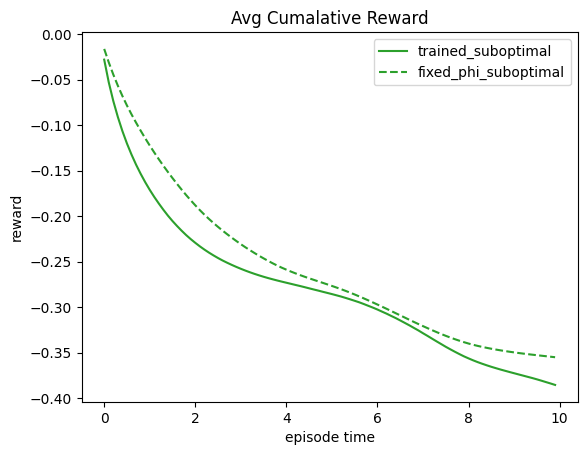

In [7]:
baseline_phi = 0.6
fixed_phi = FixedPhi(baseline_phi) # need to retune
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{baseline_phi}_10.0.pt")
compare_agents([ trained , fixed_phi],
              ["trained_suboptimal", "fixed_phi_suboptimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

In [14]:
type(fixed_phi) == RL_phi_agent

False

In [ ]:
baseline_phi = 1.1
fixed_phi = FixedPhi(baseline_phi) # need to retune
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{baseline_phi}_10.0.pt")
compare_agents([ trained , fixed_phi],
              ["trained_suboptimal", "fixed_phi_suboptimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

In [72]:
test_agent = RL_phi_agent(dims,action_scale=5.)
test_agent.load_policy(f"saved_models/abc_env_{1.5}_10.0.pt")
env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
env.limit = 10.
final_rewards1=[]
actions = []
for i in range(0,1000):
    time_step=0
    reward = 0 
    while not env.isOver():
        action=test_agent.sample_action(env.getState())
        reward += env.step(action)
        actions.append(action)
    final_rewards1.append(reward)
    env.reset()

In [82]:
fixed_phi = FixedPhi(1.5) # need to retune
env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
env.limit = 10.
final_rewards=[]
actions = []
for i in range(0,1000):
    time_step=0
    reward = 0 
    while not env.isOver():
        action=fixed_phi.sample_action(env.getState())
        reward += env.step(action)
        actions.append(action)
    final_rewards.append(reward)
    env.reset()

(-1.6, 0.0)

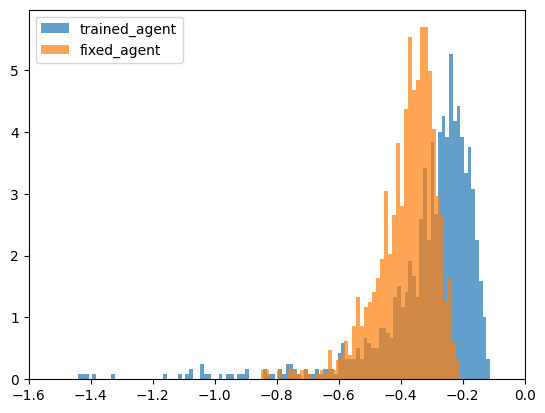

In [88]:
plt.hist(final_rewards1,bins=500,density=True,alpha=0.7)
plt.hist(final_rewards,bins=50,density=True,alpha=0.7)
plt.legend(labels=["trained_agent","fixed_agent"])
plt.xlim(-1.6,0)

(-1.6, 0.0)

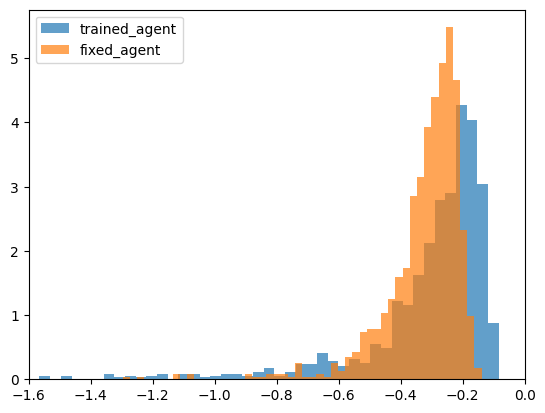

In [71]:
plt.hist(final_rewards1,bins=500,density=True,alpha=0.7)
plt.hist(final_rewards,bins=50,density=True,alpha=0.7)
plt.legend(labels=["trained_agent","fixed_agent"])
plt.xlim(-1.6,0)

In [84]:
np.median(final_rewards)

-0.3630172751201125

In [85]:
np.median(final_rewards1)

-0.2682443693961651

In [86]:
sum(final_rewards)/len(final_rewards)

-0.38147338220968197

In [87]:
sum(final_rewards1)/len(final_rewards1)

-0.32813286996224444

In [54]:
from scipy.optimize import curve_fit
from scipy.stats import norm


In [61]:
mu, sigma = norm.fit(actions)
print(f"mu:{mu} sigma:{sigma}")

mu:0.27078166604042053 sigma:0.05596719682216644


In [62]:
np.exp(-5)

0.006737946999085467